# Descripción del conjunto de datos

Debe haber una columna de predicción por imagen, y las etiquetas se representan como números enteros que corresponden cada uno a una parte del cuerpo contenida en el conjunto de datos:

* Abdomen = 0
* Tobillo = 1
* Columna cervical = 2
* Tórax = 3
* Clavículas = 4
* Codo = 5
* Pies = 6
* Dedos = 7
* Antebrazo = 8
* Mano = 9
* Cadera = 10
* Rodilla = 11
* Pierna = 12
* Columna lumbar = 13
* Otros = 14
* Pelvis = 15
* Hombro = 16
* Senos paranasales = 17
* Cráneo = 18
* Muslo = 19
* Columna torácica = 20
* Muñeca = 21

*Nota*: Otros indica si la muestra contiene imágenes no radiográficas que a veces se colocan erróneamente en el sistema PACS como radiografías (por ejemplo, esofagograma, densitometría).

### Archivos

* train.csv - el conjunto de entrenamiento. Contiene el SOPInstanceUID y la información del objetivo.
* sample_submission.csv - un archivo de presentación de muestras en el formato correcto. Contiene SOPInstanceUID para el conjunto de test.

### Columnas

* SOPInstanceUID- Cada SOPInstanceUID corresponde a una imagen única.
* Target - La etiqueta asignada a cada muestra.

# SetUp

In [61]:
!pip install pydicom


In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
import os
import pandas as pd
import numpy as np
import pydicom
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import warnings
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
import random
import zipfile
import tempfile
import shutil


warnings.filterwarnings("ignore", category=UserWarning, module="pydicom")


In [64]:
# Rutas a los directorios
train_dir = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/train'
test_dir = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/test'
train_csv = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/train.csv'
sample_submission_csv = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/sample_submission.csv'

# Cargar los datos de entrenamiento
train_df = pd.read_csv(train_csv)

# Visualizar algunas filas del DataFrame
train_df.head(10)


,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10062189329714053601...,14
1,1.2.826.0.1.3680043.8.498.53411283183733547704...,3
2,1.2.826.0.1.3680043.8.498.12955484645689261949...,3
3,1.2.826.0.1.3680043.8.498.10408703585974384892...,3
4,1.2.826.0.1.3680043.8.498.30255106562321206269...,9
5,1.2.826.0.1.3680043.8.498.80404681981834387091...,0
6,1.2.826.0.1.3680043.8.498.16743022096024694044...,2
7,1.2.826.0.1.3680043.8.498.33303514480609398517...,2
8,1.2.826.0.1.3680043.8.498.15144815417970827102...,13
9,1.2.826.0.1.3680043.8.498.19878644487806502082...,3


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1278 entries, 0 to 1277
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SOPInstanceUID  1278 non-null   object
 1   Target          1278 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.1+ KB


#Exploracion de imagenes

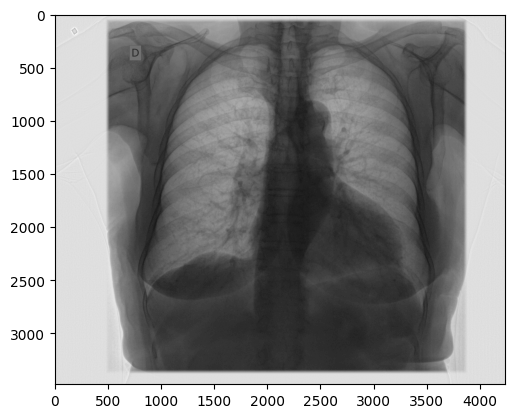

In [ ]:
def show_dicom_image_single(file_path):
    dicom = pydicom.dcmread(file_path)
    plt.imshow(dicom.pixel_array, cmap='gray')
    plt.show()

#  imagen de ejemplo
example_image_path = os.path.join(train_dir, train_df.iloc[2]['SOPInstanceUID'] + '.dcm')
show_dicom_image_single(example_image_path)


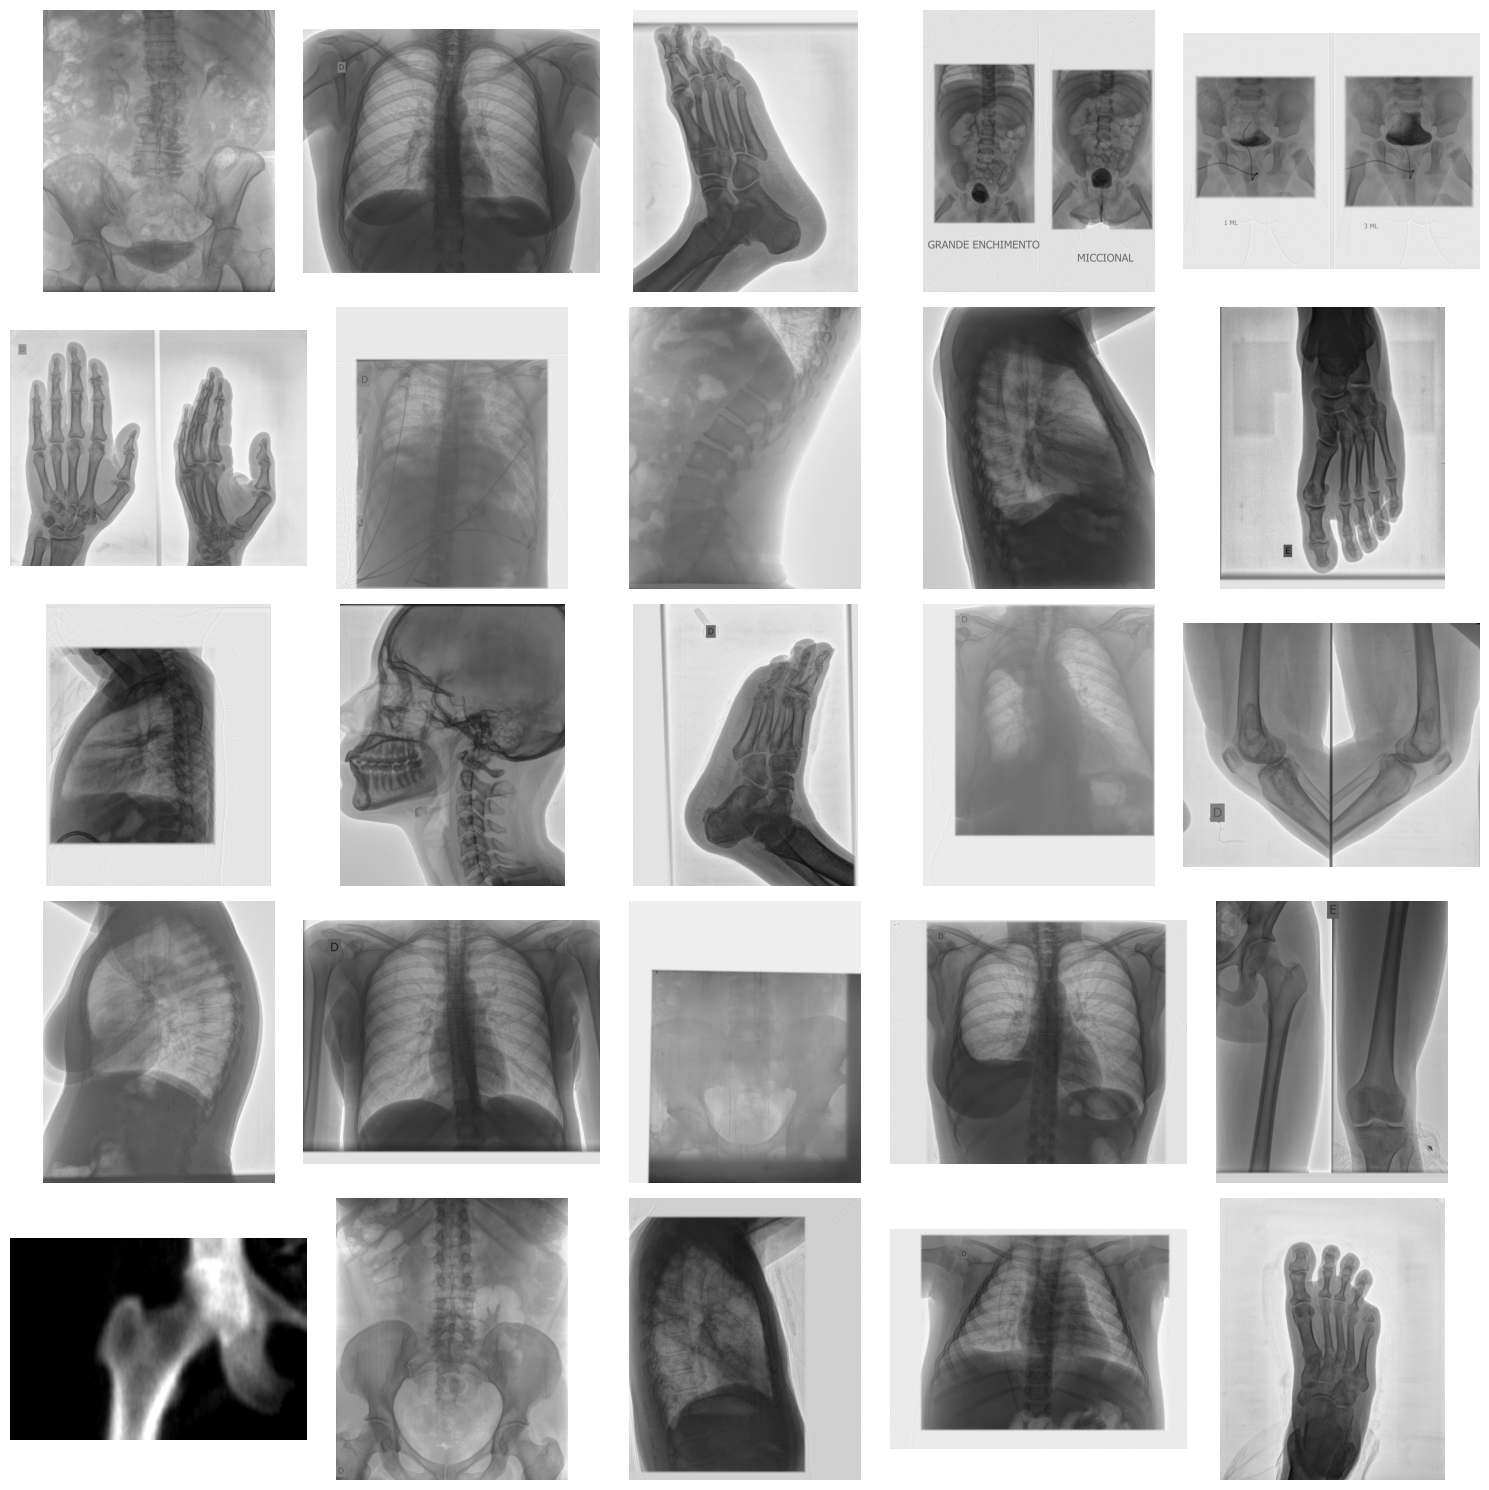

In [ ]:
def show_dicom_image_multi(file_path, ax):
    dicom = pydicom.dcmread(file_path)
    ax.imshow(dicom.pixel_array, cmap='gray')
    ax.axis('off')  # Desactivar ejes

# Seleccionar 25 imágenes al azar
random_indices = random.sample(range(len(train_df)), 25)
random_image_paths = [os.path.join(train_dir, train_df.iloc[i]['SOPInstanceUID'] + '.dcm') for i in random_indices]

# Crear una figura y ejes para una matriz de 5x5
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

# Mostrar cada imagen en su correspondiente subgráfico
for ax, image_path in zip(axes.flat, random_image_paths):
    show_dicom_image_multi(image_path, ax)

# Ajustar el espacio entre subgráficos
plt.tight_layout()
plt.show()


# Pre-procesamiento de imagenes

Ajuste de dimensiones y parametros. Aca se pueden agregar otras transformaciones y filtros para mejorar las siluetas. Tambien aplicar transformaciones que vimos en clase para reducir la dimensionalidad. Revisar

In [78]:
#Numero maximo de imagenes para entrenar el modelo
max = 1278
#1278

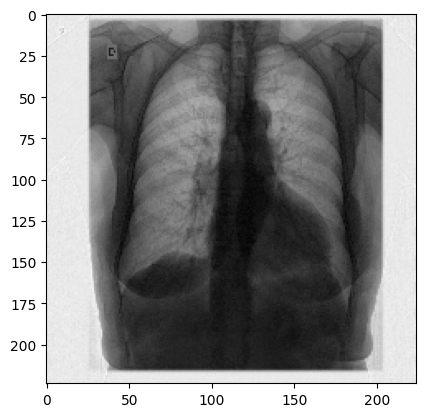

In [66]:

def preprocess_image_2c(file_path, img_size):
    dicom = pydicom.dcmread(file_path)
    img = dicom.pixel_array
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0  # Normalización
    return img


# Preprocesar una imagen de ejemplo
preprocessed_img = preprocess_image_2c(example_image_path, 224)
plt.imshow(preprocessed_img, cmap='gray')
plt.show()


### Data Augmentation
Aqui se normalizan las imagenes** redimensionandolas y duplicando un canal**
para adaptarla a 3 canales (RGB) que es el formato de entrada por defecto de Resnet 50. Tambien se aplica** data agumentation** rotando, desplazando y acercando o alegando las imagenes al azar. De esta manera el modelo se entrenara con imagenes en posiciones y formas diversas, reduciento el overfitting y mejorando la predictibilidad.

El código configura un generador de aumento de datos (`ImageDataGenerator`) con transformaciones aleatorias (rotación, desplazamiento, corte, zoom, y volteo horizontal) y define funciones para preprocesar imágenes DICOM. La función `preprocess_image` escala y normaliza las imágenes, mientras que `preprocess_image_with_augmentation` aplica además transformaciones aleatorias para aumentar la variabilidad de los datos de entrada.


In [79]:

# Configuración del generador de data augmentation
data_gen_constant = ImageDataGenerator(
    zoom_range=0.03,  # Rango de zoom aleatorio pequeño
    fill_mode='nearest',  # Modo de relleno para transformaciones de tamaño
    rotation_range=10,  # Rango de rotación en grados moderado
    width_shift_range=0.05,  # Rango de desplazamiento horizontal pequeño
    height_shift_range=0.05,  # Rango de desplazamiento vertical pequeño
    horizontal_flip=True,  # Volteo horizontal aleatorio
    vertical_flip=True  # Volteo vertical aleatorio
)


def preprocess_image(file_path, img_size):
    dicom = pydicom.dcmread(file_path)
    img = dicom.pixel_array

    # Escalar los valores de píxeles a un rango conocido, por ejemplo [0, 255]
    img = img.astype(np.float32)
    img_min = img.min()
    img_max = img.max()
    img = (img - img_min) / (img_max - img_min) * 255.0

    # Convertir a tres canales si es necesario
    if len(img.shape) == 2:  # grayscale
        img = np.stack([img] * 3, axis=-1)
    elif img.shape[-1] == 2:  # two channels
        img = np.concatenate([img, img[:, :, :1]], axis=-1)  # Duplicar un canal

    # Aplicar ecualización del histograma
    for i in range(3):  # Aplicar a cada canal por separado
        img[:, :, i] = cv2.equalizeHist(img[:, :, i].astype(np.uint8))

    # Redimensionar la imagen al tamaño deseado
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0  # Normalización a rango [0, 1]

    return img
def preprocess_image_with_augmentation(file_path, img_size):
    img = preprocess_image(file_path, img_size)  # Preprocesar la imagen sin augmentation
    img = img.reshape((1,) + img.shape)  # Reshape necesario para el generador
    img = data_gen.random_transform(img[0])  # Aplicar transformación aleatoria
    return img


### Procesamiento batch de todas las imagenes y division en test y train

La función `process_images` carga, preprocesa y aumenta un número especificado de imágenes DICOM del conjunto de datos de entrenamiento. Para cada imagen, se aplica preprocesamiento y aumento, y se recopilan las imágenes y etiquetas resultantes en arrays `X` y `y`. Luego, se codifican las etiquetas y se dividen los datos en conjuntos de entrenamiento y validación. Finalmente, la función devuelve estos conjuntos de datos listos para el entrenamiento

In [1]:
def process_images(num_images, output_zip):
    img_size = 224
    X = []
    y = []

    # Obtener la cantidad total de imágenes
    total_images = min(num_images, len(train_df))

    # Cargar y preprocesar las imágenes de entrenamiento especificadas
    for idx, row in tqdm(train_df.iterrows(), total=total_images, desc="Procesando imágenes"):
        if idx >= num_images:
            break
        img_path = os.path.join(train_dir, row['SOPInstanceUID'] + '.dcm')
        img = preprocess_image_with_augmentation(img_path, img_size)
        X.append(img)
        y.append(row['Target'])

    X = np.array(X)
    y = np.array(y)

    # Codificación de las etiquetas
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Dividir en conjuntos de entrenamiento y validación
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Guardar las imágenes y etiquetas en un archivo ZIP
    with tempfile.TemporaryDirectory() as tmpdir:
        X_train_path = os.path.join(tmpdir, 'X_train.npy')
        X_val_path = os.path.join(tmpdir, 'X_val.npy')
        y_train_path = os.path.join(tmpdir, 'y_train.npy')
        y_val_path = os.path.join(tmpdir, 'y_val.npy')

        np.save(X_train_path, X_train)
        np.save(X_val_path, X_val)
        np.save(y_train_path, y_train)
        np.save(y_val_path, y_val)

        with zipfile.ZipFile(output_zip, 'w') as zipf:
            zipf.write(X_train_path, 'X_train.npy')
            zipf.write(X_val_path, 'X_val.npy')
            zipf.write(y_train_path, 'y_train.npy')
            zipf.write(y_val_path, 'y_val.npy')

    return X_train, X_val, y_train, y_val

# Especificar la cantidad de imágenes a procesar y el nombre del archivo ZIP
num_images_to_process = max  # Máximo
output_zip = 'processed_images.zip'
X_train, X_val, y_train, y_val = process_images(num_images_to_process, output_zip)

NameError: name 'train_df' is not defined

### Revision de imagenes post tratamiento

La función `show_random_images` muestra un número especificado de imágenes aleatorias de un conjunto de datos. Selecciona índices aleatorios y muestra las imágenes correspondientes en una cuadrícula de 5x5. Cada imagen se normaliza si es necesario y se muestra en escala de grises o en color según corresponda. Se imprimen los valores máximo y mínimo de cada imagen para verificación.

In [ ]:
def show_random_images(X, num_images=25):
    # Asegurarse de que num_images no exceda el número de imágenes en X
    num_images = min(X.shape[0], num_images)
    # Seleccionar índices aleatorios
    indices = np.random.choice(X.shape[0], num_images, replace=False)

    # Configurar la figura y los ejes
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for ax, idx in zip(axes.flat, indices):
        image = X[idx]
        print("Max value:", image.max(), "Min value:", image.min())  # Imprimir valores máximos y mínimos

        # Normalizar sólo si es necesario
        if image.max() > 1:
            image = image.astype(float) / 255.0

        ax.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
        ax.set_title(f'Index: {idx}', fontsize=8)
        ax.axis('off')

    plt.show()

# Asegúrate de que X_train o X_val esté definido y contenga datos.
show_random_images(X_train, num_images=25)

# Modelo

### Entrenamiento

Usamos el modelo ResNet50 preentrenado con entrada de tres canales. Estamos agregando un canal vacio para poder usar este modelo. Ojo, revisar esto, podemos optar por usar modelos bidimensionales.** Hay que hacer un research a ver que modelo es mas conveniente**. Agregar mas metricas de performance.

ResNet, que significa "Redes Residuales", es una arquitectura de red neuronal convolucional (CNN) desarrollada por Microsoft Research en 2015. ResNet introdujo el concepto de "skip connections" o "conexiones residuales", que permiten que las redes neuronales profundas se vuelvan aún más profundas sin sufrir el problema de degradación de la precisión.


'Un "epoch" en el contexto del entrenamiento de modelos de aprendizaje automático se refiere a una pasada completa de todos los ejemplos de entrenamiento a través del modelo. En otras palabras, durante un epoch, el modelo ve todos los ejemplos de entrenamiento una vez y ajusta sus pesos en consecuencia para mejorar su desempeño.

Durante el entrenamiento de un modelo, los datos de entrenamiento se dividen en lotes de un tamaño específico (por ejemplo, 32, 64, etc.). Durante cada epoch, el modelo pasa por todos los lotes de entrenamiento, calcula la pérdida y ajusta sus pesos utilizando un algoritmo de optimización, como el descenso del gradiente estocástico (SGD) o Adam. Después de pasar por todos los lotes de entrenamiento, se completa un epoch y el modelo pasa al siguiente epoch.

El número de epochs que se especifica en el entrenamiento del modelo (epochs=10 en tu caso) indica cuántas veces se repetirá este proceso completo de pasar por todos los ejemplos de entrenamiento. A menudo, se requieren múltiples epochs para que el modelo aprenda patrones complejos en los datos y mejore su rendimiento. Sin embargo, es importante evitar el sobreajuste al entrenar demasiado tiempo, por lo que es común utilizar técnicas como el early stopping para detener el entrenamiento una vez que el rendimiento en el conjunto de validación deja de mejorar.'

In [ ]:
# Construcción del modelo
input_tensor = Input(shape=(224, 224, 3))
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(22, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Compilación del modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callback para detener el entrenamiento temprano si no hay mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenamiento del modelo
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[early_stopping])

# Evaluar el modelo
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

### Analisis de imagenes del sample_sumission y aplicacion de predicciones

El código lee un archivo CSV de muestras de prueba (`test_df`) y analiza todas las imágenes de prueba para aplicar predicciones utilizando el modelo entrenado. Para cada imagen, se realiza el preprocesamiento, se expande la dimensión para ajustarse a la entrada del modelo, y se predice la etiqueta de la imagen. Las predicciones se almacenan en una lista (`predictions`).


In [ ]:
# Cargar el DataFrame de las imágenes de prueba
test_df = pd.read_csv(sample_submission_csv)

predictions = []

# Crear una barra de progreso acumulativo
pbar = tqdm(total=len(test_df), desc="Analizando imágenes de test")

# Analizar todas las imágenes y aplicar predicciones del modelo
for idx, row in test_df.iterrows():
    img_path = os.path.join(test_dir, row['SOPInstanceUID'] + '.dcm')
    img = preprocess_image(img_path, 224)
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img, verbose=0)  # verbose=0 para suprimir la salida
    pred_label = np.argmax(pred, axis=1)
    predictions.append(pred_label[0])

    # Actualizar la barra de progreso
    pbar.update(1)

# Cerrar la barra de progreso
pbar.close()

# Convertir las predicciones a un array de numpy
predictions = np.array(predictions)

# Guardar las predicciones en un archivo ZIP
output_zip = 'test_predictions.zip'
with tempfile.TemporaryDirectory() as tmpdir:
    predictions_path = os.path.join(tmpdir, 'predictions.npy')
    np.save(predictions_path, predictions)

    with zipfile.ZipFile(output_zip, 'w') as zipf:
        zipf.write(predictions_path, 'predictions.npy')

# Creacion del sample_sumission.csv e imputacion de predicciones

In [ ]:
# preparacion del df
submission_df = test_df.copy()
submission_df['Target'] = predictions
submission_df.to_csv('/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/GitHub/GitHub_Repositorios/dp4_team2/sample_submission_cris.csv', index=False)
submission_df


# Análisis de resultados

El código realiza una distribución de las predicciones de (`submission_df`) agrupando las predicciones por el valor de la columna 'Target'. Se crea un diccionario para mapear los números de la columna 'Target' con los nombres de las partes del cuerpo correspondientes. Luego, se calcula la frecuencia de cada categoría, se agrega el nombre de la sección utilizando el diccionario y se calcula el porcentaje de cada categoría en relación con el total de predicciones.


In [ ]:
#Distribucion de predicciones

grouped = submission_df.groupby('Target').size().reset_index(name='Frecuencia')

# Diccionario que mapea los números de la columna 'Target' con los nombres de partes del cuerpo
id = {
    0: 'Abdomen',
    1: 'Tobillo',
    2: 'Columna cervical',
    3: 'Tórax',
    4: 'Clavículas',
    5: 'Codo',
    6: 'Pies',
    7: 'Dedos',
    8: 'Antebrazo',
    9: 'Mano',
    10: 'Cadera',
    11: 'Rodilla',
    12: 'Pierna',
    13: 'Columna lumbar',
    14: 'Otros',
    15: 'Pelvis',
    16: 'Hombro',
    17: 'Senos paranasales',
    18: 'Cráneo',
    19: 'Muslo',
    20: 'Columna torácica',
    21: 'Muñeca'
}

# Nuevas columnas y agrupaciones
grouped['Seccion'] = grouped['Target'].map(id)
grouped_sorted = grouped.sort_values(by='Frecuencia', ascending=False)
total = grouped_sorted['Frecuencia'].sum()
grouped_sorted['%'] = (grouped_sorted['Frecuencia'] / total) * 100


grouped_sorted
